In [1]:
import pandas as pd
import numpy as np
import math
from matplotlib import pyplot as plt
from src.hdmm import workload, fairtemplates, error, fairmechanism, matrix, mechanism, templates

In [2]:
def pmw(workload, x, eps=13, beta=0.1, laplace_scale=1):
    """
    Implement Private Multiplicative Weights Mechanism (PMW) on a workload of
    linear queries. New arguments to allow for optimizing the amount of
    privacy budget used in each step.

    Returns pandas df with test data for each query (query, d_t_hat, updated,
    algo_ans, real_ans, abs_error, rel_error). 

    - W = workload of queries (M x k numpy array)
    - x = true database (M x 1 numpy array)
    """ 
    
    # initialize constants
    m = x.size  # database len
    n = x.sum()  # database sum
    k = len(workload)  # num of queries
    delta = 1 / (n * math.log(n, np.e))
    x_norm = x / np.sum(x)
    eta = math.log(m, np.e) ** (1 / 4) / math.sqrt(n)
    sigma = 10 * math.log(1 / delta, np.e) * (math.log(m, np.e)) ** (1 / 4) / (
            math.sqrt(n) * eps)
    threshold = 4 * sigma * (math.log(k, np.e) + math.log(1 / beta, np.e))
    
    # synthetic databases at time 0 (prior to any queries)
    y_t = np.ones(m) / m
    x_t = np.ones(m) / m

    # append to list of databases y_t and x_t
    y_list = [y_t]
    x_list = [x_t]
    
    update_list = []
    update_count = 0
    algo_answers = []
    update_times = []
    d_t_hat_list = []
    # iterate through time = (0, k)
    for time, query in enumerate(workload):

        # compute noisy answer by adding Laplacian noise
        a_t = np.random.laplace(loc=0, scale=laplace_scale, size=1)[0]
        a_t_hat = np.dot(query, x_norm) + a_t

        # difference between noisy and maintained histogram answer
        d_t_hat = a_t_hat - np.dot(query, x_list[time])
        d_t_hat_list.append(d_t_hat)

        # lazy round: use maintained histogram to answer the query
        if abs(d_t_hat) <= threshold:
            algo_answers.append(np.dot(query, x_list[time]))
            x_list.append(x_list[time])
            update_list.append('no')
            continue

        # update round: update histogram and return noisy answer
        else:
            update_list.append('yes')
            update_times.append(time)

            # step a
            if d_t_hat > 0:
                r_t = query
            else:
                r_t = np.ones(m) - query
            for i, v in enumerate(y_t):
                y_t[i] = x_list[time][i] * math.exp(-eta * r_t[i])
            y_list.append(y_t)

            # step b
            x_t = y_t / np.sum(y_t)
            x_list.append(x_t)
        
        update_count = update_list.count('yes')

        if update_count > n * math.log(m, 10) ** (1 / 2):
            return "failure"
        else:
            algo_answers.append(a_t_hat / np.sum(x))

    # calculate error
    real_ans = np.matmul(workload, x_norm)
    abs_error = np.abs(algo_answers - real_ans)
    rel_error = np.abs(algo_answers / np.where(real_ans == 0, 0.000001,
                                                real_ans))

    def print_outputs():
        """Print inputes/outputs to analyze each query"""
        print(f'Original database: {x}\n')
        print(f'Normalized database: {x_norm}\n')
        print(f'Updated Database = {x_t}\n')
        print(f'Update Count = {update_count}\n')
        print(f'{threshold=}\n')
    print_outputs()
    
    def plot_error():
        """Plot absolute and relative error"""
        plt.xticks(range(0, k, 5))
        plt.title('Error across queries:')
        rel_line, = plt.plot(rel_error, label='Relative Error')
        abs_line, = plt.plot(abs_error, label='Absolute Error')
        for xc in update_times:
            plt.axvline(x=xc, color='red', label='Update Times', linestyle='dashed')
        plt.legend(handles=[rel_line, abs_line])
    plot_error()
    
    d = {
                'queries': workload.tolist(), 
                'd_t_hat': d_t_hat_list, 
                'updated': update_list,
                'algo_ans': algo_answers,
                'real_ans': real_ans.tolist(),
                'abs_error': abs_error,
                'rel_error': rel_error,
             }
    test_data = pd.DataFrame(data=d)

    return test_data


In [3]:
x_peaks = np.array([1000, 8000, 1300, 1250, 9000, 1450, 1700, 1720])
W_allrange = workload.AllRange(8).dense_matrix()

Original database: [1000 8000 1300 1250 9000 1450 1700 1720]

Normalized database: [0.0393391  0.31471282 0.05114083 0.04917388 0.35405193 0.0570417
 0.06687648 0.06766326]

Updated Database = [0.1248811  0.1248811  0.12582523 0.1248811  0.1248811  0.12394405
 0.1248811  0.12582523]

Update Count = 6

threshold=1.6996721141306268



,queries,d_t_hat,updated,algo_ans,real_ans,abs_error,rel_error
0,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",-1.030933,no,0.125000,0.039339,0.085661,3.177500
1,"[1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",0.708851,no,0.250000,0.354052,0.104052,0.706111
2,"[1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0]",2.548889,yes,0.000115,0.405193,0.405078,0.000284
3,"[1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0]",0.807997,no,0.498589,0.454367,0.044222,1.097328
4,"[1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0]",0.404106,no,0.623942,0.808419,0.184477,0.771805
5,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0]",-0.679885,no,0.749295,0.865460,0.116166,0.865776
6,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0]",0.440934,no,0.874647,0.932337,0.057689,0.938124
7,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]",-0.364772,no,1.000000,1.000000,0.000000,1.000000
8,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",0.305876,no,0.124412,0.314713,0.190301,0.395320
9,"[0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0]",0.536680,no,0.248824,0.365854,0.117029,0.680120


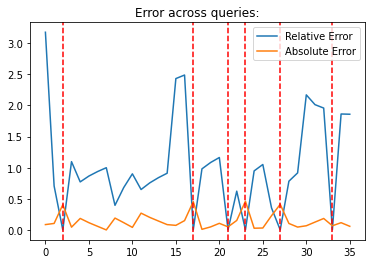

In [4]:
pmw(W_allrange, x_peaks, eps=13)

The updated database and the original normalized database are really different. Furthermore, the relative error is extremely high (3 and 2.5-fold), which is abnormal. The relative error should definitely be decently below 1. The database needs to update more. 

In [5]:
query_a = np.array([[1,0,0,0,0,0,0,0],
                    [0,1,0,0,0,0,0,0]])

query_b = np.array([[0,0,1,0,0,0,0,0],
                    [0,0,0,1,0,0,0,0]])

Original database: [1000 8000 1300 1250 9000 1450 1700 1720]

Normalized database: [0.0393391  0.31471282 0.05114083 0.04917388 0.35405193 0.0570417
 0.06687648 0.06766326]

Updated Database = [0.12406118 0.12594414 0.12499911 0.12499911 0.12499911 0.12499911
 0.12499911 0.12499911]

Update Count = 2

threshold=0.8650480147063264



,queries,d_t_hat,updated,algo_ans,real_ans,abs_error,rel_error
0,"[1, 0, 0, 0, 0, 0, 0, 0]",1.539492,yes,0.000065,0.039339,0.039274,0.001664
1,"[0, 1, 0, 0, 0, 0, 0, 0]",-1.014957,yes,-0.000035,0.314713,0.314748,0.000111


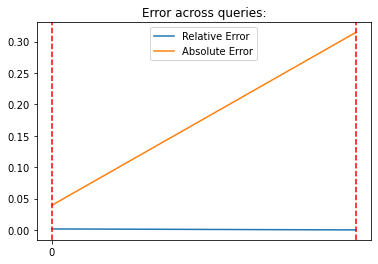

In [6]:
pmw(query_a, x_peaks, eps=13)

Original database: [1000 8000 1300 1250 9000 1450 1700 1720]

Normalized database: [0.0393391  0.31471282 0.05114083 0.04917388 0.35405193 0.0570417
 0.06687648 0.06766326]

Updated Database = [0.125 0.125 0.125 0.125 0.125 0.125 0.125 0.125]

Update Count = 0

threshold=1384.7616622404153



,queries,d_t_hat,updated,algo_ans,real_ans,abs_error,rel_error
0,"[1, 0, 0, 0, 0, 0, 0, 0]",0.198355,no,0.125,0.039339,0.085661,3.177500
1,"[0, 1, 0, 0, 0, 0, 0, 0]",-0.700501,no,0.125,0.314713,0.189713,0.397188
2,"[0, 0, 1, 0, 0, 0, 0, 0]",0.543051,no,0.125,0.051141,0.073859,2.444231
3,"[0, 0, 0, 1, 0, 0, 0, 0]",0.798288,no,0.125,0.049174,0.075826,2.542000


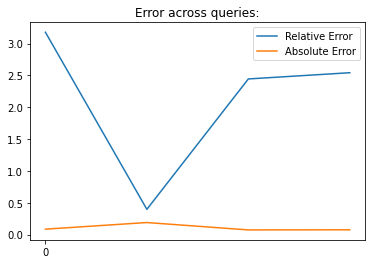

In [7]:
pmw(np.vstack((query_a, query_b)), x_peaks, eps=0.01)